In [1]:
%load_ext autoreload
%autoreload 2

# Exploration of Dask

In [2]:
from impresso_commons.utils.s3 import IMPRESSO_STORAGEOPT
import dask.dataframe as ddf

In [3]:
PATH = '/scratch/students/justine/'
FILE = 's3-impresso-stats'

In [4]:
test_df = ddf.read_csv(
    PATH+FILE+"/content-item-stats/*",
    storage_options=IMPRESSO_STORAGEOPT
)

In [5]:
# Specify path for imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Explore dataframe

### Snapshots

In [6]:
test_df.head(5)

,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN


In [7]:
test_df.tail(5)

,id,year,newspaper,type,n_tokens,title_length
173,waeschfra-1884-07-05-a-i0017,1884,waeschfra,ar,19.0,NaN
174,waeschfra-1884-07-05-a-i0018,1884,waeschfra,img,NaN,NaN
175,waeschfra-1884-07-05-a-i0019,1884,waeschfra,img,NaN,NaN
176,waeschfra-1884-07-05-a-i0020,1884,waeschfra,img,NaN,NaN
177,waeschfra-1884-07-05-a-i0021,1884,waeschfra,img,NaN,NaN


In [8]:
%time test_df.head(1000,npartitions=3)

CPU times: user 427 ms, sys: 71.8 ms, total: 499 ms
Wall time: 475 ms


,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN
...,...,...,...,...,...,...
538,BNN-1886-01-30-a-i0017,1886,BNN,ar,102.0,14.0
539,BNN-1886-01-30-a-i0018,1886,BNN,ar,136.0,35.0
540,BNN-1886-01-30-a-i0019,1886,BNN,ar,8.0,13.0
541,BNN-1886-01-30-a-i0020,1886,BNN,ar,39.0,19.0


### Info in the type column

In [9]:
%time 
ci_types = test_df.type.unique().compute()

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 16.9 µs


### Try filtering

In [10]:
%%time 
BDC_ar_df = test_df[(test_df.newspaper=='BDC') & (test_df.type=='ar')].compute()

CPU times: user 1min 41s, sys: 26 s, total: 2min 7s
Wall time: 1min 9s


---

## Statistics

### Number of rows

In [11]:
%time test_df.shape[0].compute()

CPU times: user 1min 28s, sys: 18.7 s, total: 1min 47s
Wall time: 57 s


47876994

### Number of content items through time

#### Add decade column

In [12]:
from impresso_stats.helpers import decade_from_year_df

In [13]:
test_df = decade_from_year_df(test_df, dask_df = True)

In [14]:
test_df.head()

,id,year,newspaper,type,n_tokens,title_length,decade
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,1830
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,1830
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,1830
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,1830
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,1830


---

## Plots
### 1D Function

In [15]:
from impresso_stats.visualization import plt_freq_ci_1d

In [16]:
# Use later for improvement
'''type_dict = {'ar': 'article', 
             'ad': 'advertisment', 
             'img': 'image', 
             'page': 'page', 
             'ob':'ob', 
             'tb': 'tb', 
             'section': 'section',
             'w': 'weather',
             'picture': 'picture'}'''

"type_dict = {'ar': 'article', \n             'ad': 'advertisment', \n             'img': 'image', \n             'page': 'page', \n             'ob':'ob', \n             'tb': 'tb', \n             'section': 'section',\n             'w': 'weather',\n             'picture': 'picture'}"

#### Uncomment the cels below if you start directly from here and want to retrieve the stored dataframe 
(You will also need to run the import cells above)

In [17]:
#storage_path = '/scratch/students/justine/'

In [18]:
#test_df.to_parquet(storage_path + 'content-item.parquet')

In [19]:
#test_df = ddf.read_parquet(storage_path + 'content-item.parquet')

#### Plotting fonction for the content item frequency, aggregated at one level
- type
- year
- decade
- newspaper

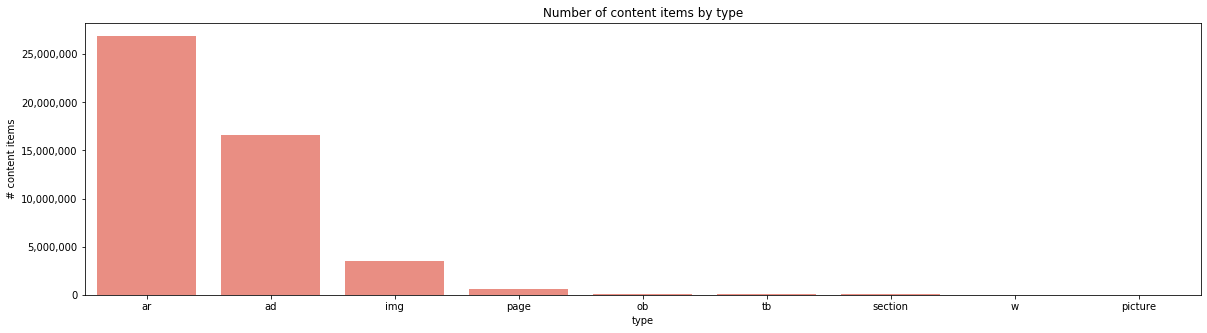

In [20]:
#Type
plt_freq_ci_1d(test_df, 'type')

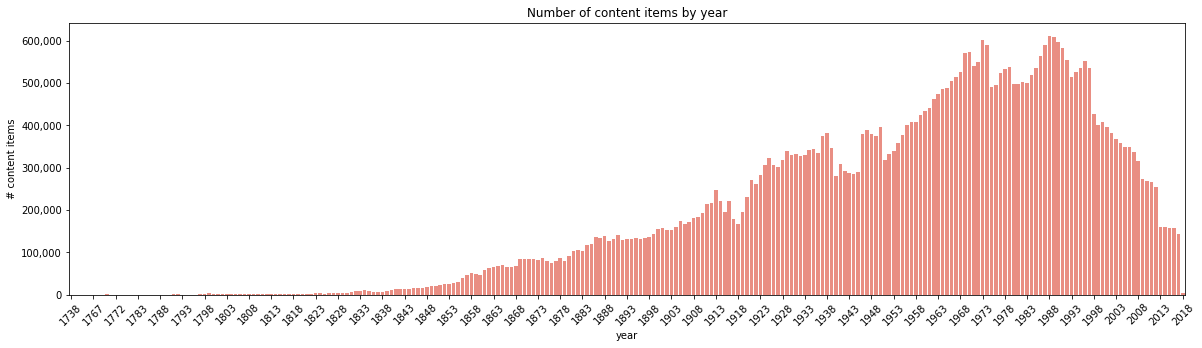

In [22]:
#Year
plt_freq_ci_1d(test_df, 'year')

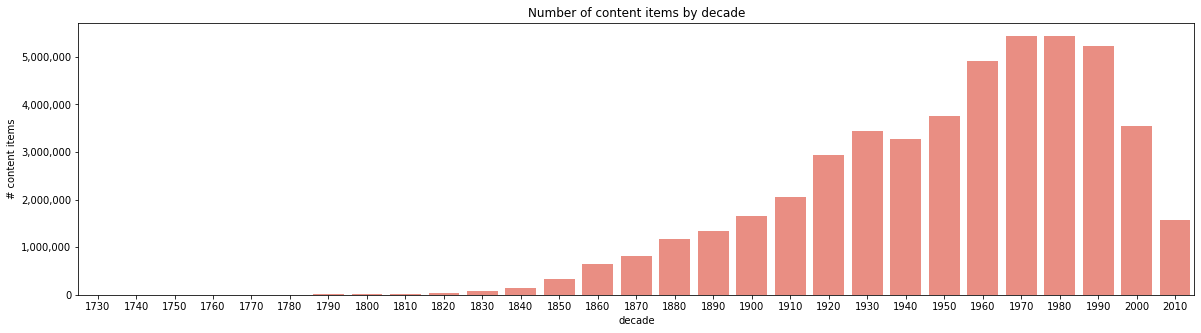

In [23]:
#Decade
plt_freq_ci_1d(test_df, 'decade')

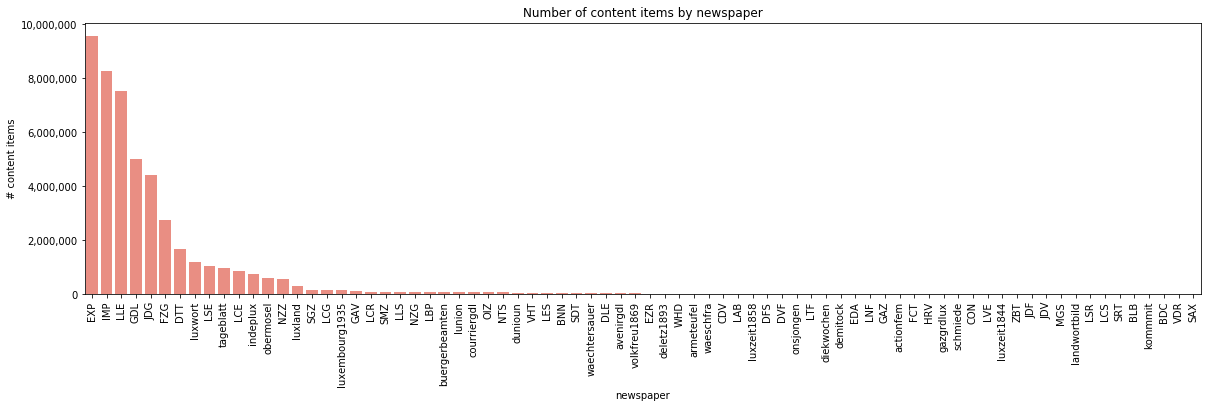

In [24]:
#Newspaper
plt_freq_ci_1d(test_df, 'newspaper')

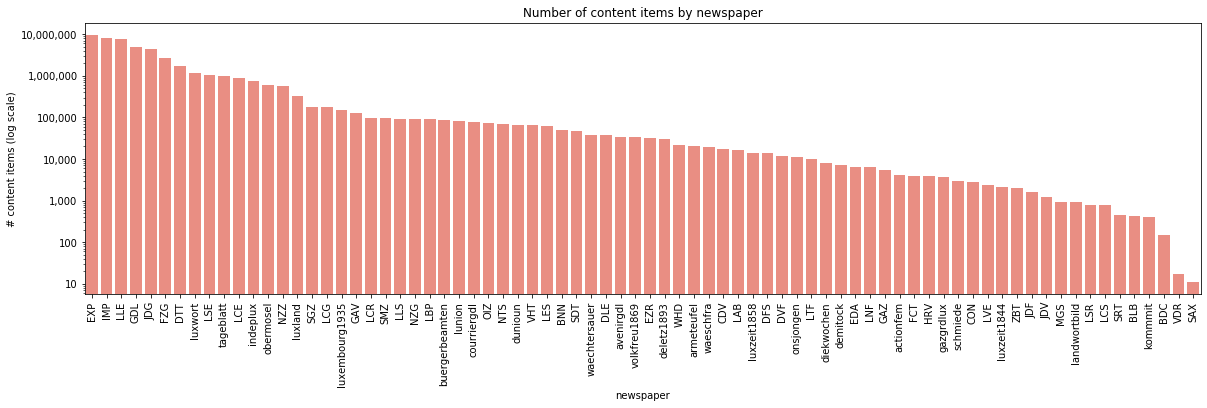

In [25]:
#Newspaper logarithmic scale
plt_freq_ci_1d(test_df, 'newspaper', log_y=True)

---

## Join with issues table (for licenses)

#### Create column issue id

In [26]:
# Extract issue_id from content item id
test_df['issue_id'] = test_df.id.apply(lambda x: x[:x.rfind("-")], meta=str)

In [27]:
test_df.head()

,id,year,newspaper,type,n_tokens,title_length,decade,issue_id
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,1830,BDC-1839-01-20-a
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,1830,BDC-1839-01-20-a
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,1830,BDC-1839-01-20-a
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,1830,BDC-1839-01-20-a
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,1830,BDC-1839-01-20-a


#### Merging function

In [29]:
from impresso_stats.sql import db_engine, read_table

In [41]:
def ar_content_item_df(ci_df):
    
    # Read df with access rights (as issues level) from sql
    engine = db_engine()
    issues_df = read_table('impresso.issues', engine)
    
    # Rename column 'id' to avoid name conflicts 
    issues_df = issues_df.rename(columns={"id": "issue_id"})
    
    # Merge dfs
    merged_df = ci_df.merge(issues_df, on='issue_id', suffixes=('_ci', '_issue'))
    
    # Select relevant columns and rename column year for compatibility with package functions
    merged_df = merged_df[['id', 'newspaper_id', 'type', 'n_tokens', 'year_issue', 'month', 'day', \
                                   'access_rights']].rename(columns={'year_issue':'year'})
    
    return merged_df

In [42]:
merged_df = ar_content_item_df(test_df)

In [43]:
merged_df.head()

,id,newspaper_id,type,n_tokens,year,month,day,access_rights
0,BDC-1839-01-20-a-i0001,BDC,ar,250.0,1839,1,20,OpenPublic
1,BDC-1839-01-20-a-i0002,BDC,ar,758.0,1839,1,20,OpenPublic
2,BDC-1839-01-20-a-i0003,BDC,ar,14.0,1839,1,20,OpenPublic
3,BDC-1839-01-20-a-i0004,BDC,ar,349.0,1839,1,20,OpenPublic
4,BDC-1839-01-20-a-i0005,BDC,ar,193.0,1839,1,20,OpenPublic


In [36]:
%time merged_df.shape[0].compute()

CPU times: user 6min 23s, sys: 59.5 s, total: 7min 23s
Wall time: 5min 16s


33707113

#### Number of content-item per access right

In [60]:
%%time
ar_per_CI = merged_df[['id', 'access_rights']].groupby('access_rights').id.count().compute()

CPU times: user 5min 47s, sys: 34.7 s, total: 6min 22s
Wall time: 4min 24s


In [61]:
ar_per_CI

access_rights
OpenPublic      1427254
OpenPrivate    29158736
Closed          3121123
Name: id, dtype: int64

#### Plot

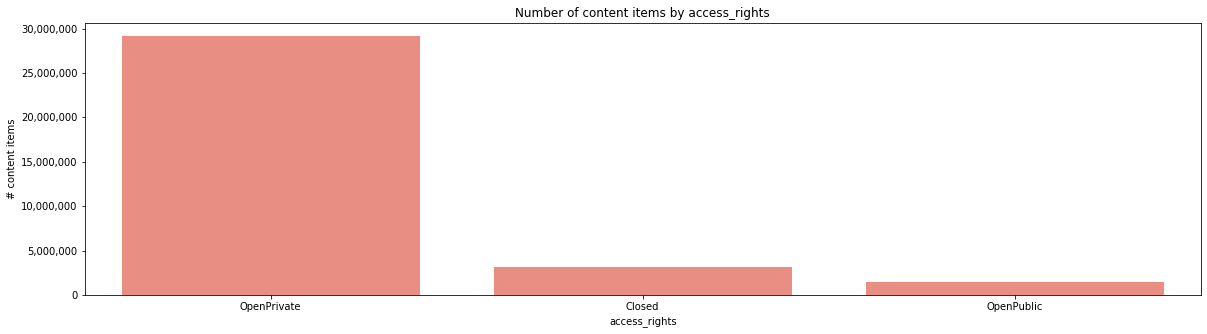

In [37]:
plt_freq_ci_1d(merged_df, 'access_rights')

---

## Stop here : The following cells are not cleaned (not relevant for now)

## Filter content item dataframe

### Test filter function with several parameters on dask df

In [62]:
from helpers import filter_df

In [63]:
ar_content_item_sub,_ = filter_df(ar_content_item, np_ids=['GDL', 'NZZ', 'JDG'], start_date=1780, end_date=1810)

Following cell takes 7min to run : outputs 24'294 >> can be converted to pandas df

In [ ]:
%time ar_content_item_sub.shape[0].compute()

In [ ]:
ar_content_item_sub_pd = ar_content_item_sub.compute()

In [ ]:
ar_content_item_sub_pd

In [ ]:
from visualization import plot_licences

In [ ]:
plot_licences(facet='time', df=ar_content_item_sub_pd)

In [ ]:
plot_licences(facet='newspapers', df=ar_content_item_sub_pd)

In [ ]:
import pandas
from typing import Iterable

In [ ]:
## TODO : FINISH THIS
def plot_licences_content_it(
    facet: str = 'newspapers',
    ddf: pandas.core.frame.DataFrame = None,
    start_date: int = None,
    end_date: int = None,
    np_ids: Iterable = None,
    country: str = None,
    batch_size: int = None,
    ppty: str = None,
    ppty_value: str = None,
) :
    
    ddf_sub,_ = filter_df(ddf, start_date, end_date, np_ids, country, ppty, ppty_value)
    #TODO : add condition on the size of teh df before calling compute()
    df = ddf_sub.compute()
    plot_licences(facet=facet, df=df)
    

## Others

In [ ]:
def np_pd(ddf, npID: str, max_rows: int):
    if len(ddf.loc[ddf.newspaper == npID] < max_rows) :
        return ddf.loc[ddf.newspaper == npID].compute()
    else :
        print('Length of dataframe exceeds max_rows > cannot be converted to pandas df.')
        return None

In [ ]:
def num_content_items(npID: str):
    return test_df.loc[test_df.newspaper == npID].count().compute()

In [37]:
def num_content_items2(npID: str):
    return test_df.filter(test_df.newspaper == npID).count().compute()

In [38]:
%time num_content_items2('BDC')

AttributeError: 'DataFrame' object has no attribute 'filter'

In [49]:
%time num_content_items('BLB')

CPU times: user 3min 23s, sys: 6min 52s, total: 10min 15s
Wall time: 1min 2s


id              429
year            429
newspaper       429
type            429
n_tokens        429
title_length    429
dtype: int64

In [26]:
%time test_df.loc[test_df.newspaper == 'BDC'].compute()

CPU times: user 3min 24s, sys: 6min 44s, total: 10min 9s
Wall time: 1min 1s


,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN
...,...,...,...,...,...,...
7,BDC-1839-04-04-a-i0002,1839,BDC,ar,713.0,NaN
8,BDC-1839-04-04-a-i0003,1839,BDC,ar,773.0,NaN
9,BDC-1839-04-04-a-i0004,1839,BDC,ar,396.0,NaN
10,BDC-1839-04-04-a-i0005,1839,BDC,ar,336.0,NaN
